# t-SNE and LDA: topic modelling guide

This tutorial will show how to reproduce what DELab has done in its topic modelling exercise on tech articles: https://towardsdatascience.com/mapping-the-tech-world-with-t-sne-7be8e1703137


https://fwd.delabapps.eu/topic_modelling.html

The packages required are:
* [openTSNE](https://opentsne.readthedocs.io/en/latest/). There are multiple other implementations of t-SNE, including sklearn's more common one, or FIt-SNE: a faster implementation. We feel that openTSNE is just the right balance between easy-to-use, fast and powerful.
* pandas, numpy, scikit-learn (data processing)
* matplotlib, plotly (visualization)

All other libraries used are included in default Python.

# You need to run the following cells:

### Transformation

This cell creates pickle files, one with articles from chosen sources (some columns from source files are removed), one with True/False values whether a particular article contains the test_word. Files are sorted to maintain comparability across machines.

In [3]:
from main_settings import res, sources, text_column, date_column, name,\
test_word, svd_dimensions, min_count_value, perps
import pandas as pd
import numpy as np
import pickle
import os
from ast import literal_eval
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from datetime import datetime
from openTSNE import TSNEEmbedding, affinity, initialization, TSNE
from openTSNE.callbacks import ErrorLogger
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from plotly.offline import plot

In [46]:
df = pd.read_pickle(res + 'data_all.pickle')
df = df.reset_index(drop=True)
df[text_column + '_token_count'] = df[text_column + '_token_count'].apply(literal_eval)
for col in [x for x in df.columns if x != text_column + '_token_count' and str(x).startswith(text_column)]:
    del df[col]

df.sort_values(date_column, inplace=True)
df.to_pickle(os.path.join(res, '{}_df.pickle'.format(name)))
facebook_in = df[text_column + '_token_count'].apply(lambda x: test_word in x).values
pickle.dump(facebook_in, open(os.path.join(res, '{}_word_indices.pickle'.format(name)), 'wb'))

### tf-idf and SVD
First, [tf-idf transformation](https://en.wikipedia.org/wiki/Information_retrieval) is computed on the term-document matrix. We restrict the words so that only more common ones are taken into account: rare words may introduce noise and increase memory requirements for the very next step. Then it is transformed by [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) to reduce the number of dimesions, as set in main_settings.

In [47]:
df = pd.read_pickle(os.path.join(res, '{}_df.pickle'.format(name)))
print(df.columns)
v = DictVectorizer()
X = v.fit_transform(df[text_column + '_token_count'])
alls = pd.DataFrame()
    
indices_min_count = np.where((X > 0).sum(axis=0) >= min_count_value)[1]
X_sh = X.tocsc()[:, indices_min_count]
    
print('start', datetime.now())
tfidf = TfidfTransformer()
X_sh_tfidf = tfidf.fit_transform(X_sh)
print('tfidf fit done', datetime.now())
svd = TruncatedSVD(n_components=svd_dimensions, random_state=2019)
X_svd = svd.fit_transform(X_sh_tfidf)
print('svd fit done', datetime.now())
pickle.dump(X_svd, open(os.path.join(res, '{}_X_svd.pickle'.format(name)), 'wb'))

Index([         'level_0',            'index',       'Unnamed: 0',
                  'title',             'site',              'url',
             'year_month',        'full_date', 'text_token_count',
                        0,                  2,                  9,
                       21,                 22,                 23,
                       25,                 27,                 29,
                       11,                 13,                  1,
                       12,                 26,                 16,
                        5,                 28,                  3,
                        6,                 20,                 14,
                        8,                 10,                 17,
                        4,                 15,                 19,
                        7,                 24,                 18,
                 'topic0',           'topic1',           'topic2',
                 'topic3',           'topic4',           'topi

### t-SNE
As the main cell, it does all the t-SNE transformations required. It uses two perplexity values and settings in general as in [official example in openTSNE](https://github.com/pavlin-policar/openTSNE/blob/master/docs/source/examples/03_preserving_global_structure/03_preserving_global_structure.rst). First, it creates an embedding with a chosen initialization. Random distributes points randomly across the two-dimensional space, PCA is Principal Component Analysis – which is not sufficient on its own to create a valuable 2-D visualization, but is helpful as a starting point, as iterations should converge quicker and crucially with more global structure maintained. Global structure is also the goal of multiple perplexity values: the first training with high perplexity is supposed to find the larger clusters, the second with the smaller value finds smaller structure: subtopics.

The figures below show the evolution of the clusters: 
- we begin with a cloud in the middle (points placed randomly or with PCA)
- T-sne with high perplexity with 250 iterations
- T-sne with high perplexity with 750 iterations
- T-sne with low perplexity with 500 iterations

With the final trainings we can see smaller, local structures in the data 




In [48]:
print('Perlexity values:'+str(perps))

Perlexity values:[300, 25]


random 2020-03-26 16:49:42.070787
perplexity nn done 2020-03-26 16:49:52.222039
embedding done 2020-03-26 16:49:52.226102


0 -3.9224002516183423 3.377768241289362
Iteration   50, KL divergence  2.4725, 50 iterations in 17.6520 sec
Iteration  100, KL divergence  1.8827, 50 iterations in 21.8198 sec
Iteration  150, KL divergence  1.6581, 50 iterations in 17.4148 sec
Iteration  200, KL divergence  1.5532, 50 iterations in 17.3214 sec
Iteration  250, KL divergence  1.4948, 50 iterations in 17.5824 sec


1 -11.842267977097183 11.650357827865093
Iteration   50, KL divergence  1.4318, 50 iterations in 17.9207 sec
Iteration  100, KL divergence  1.4045, 50 iterations in 18.7773 sec
Iteration  150, KL divergence  1.3914, 50 iterations in 18.5978 sec
Iteration  200, KL divergence  1.3825, 50 iterations in 17.6337 sec
Iteration  250, KL divergence  1.3746, 50 iterations in 17.5407 sec
Iteration  300, KL divergence  1.3698, 50 iterations in 17.5496 sec
Iteration  350, KL divergence  1.3648, 50 iterations in 17.6134 sec
Iteration  400, KL divergence  1.3618, 50 iterations in 17.5576 sec
Iteration  450, KL divergence  1.3598, 50 iterations in 17.5623 sec
Iteration  500, KL divergence  1.3590, 50 iterations in 17.7013 sec
Iteration  550, KL divergence  1.3571, 50 iterations in 18.4635 sec
Iteration  600, KL divergence  1.3546, 50 iterations in 17.7347 sec
Iteration  650, KL divergence  1.3537, 50 iterations in 17.9777 sec
Iteration  700, KL divergence  1.3535, 50 iterations in 18.3425 sec
Iterati

2 -28.899641920598295 25.37747454366387
Iteration   50, KL divergence  2.2569, 50 iterations in 2.0571 sec
Iteration  100, KL divergence  2.1958, 50 iterations in 2.1487 sec
Iteration  150, KL divergence  2.1299, 50 iterations in 2.3071 sec
Iteration  200, KL divergence  2.0688, 50 iterations in 2.6129 sec
Iteration  250, KL divergence  2.0175, 50 iterations in 2.8611 sec
Iteration  300, KL divergence  1.9781, 50 iterations in 3.0469 sec
Iteration  350, KL divergence  1.9478, 50 iterations in 3.1324 sec
Iteration  400, KL divergence  1.9260, 50 iterations in 3.7007 sec
Iteration  450, KL divergence  1.9075, 50 iterations in 3.5826 sec
Iteration  500, KL divergence  1.8906, 50 iterations in 3.9067 sec


3 -46.747029637245014 49.354547932164564
embedding optimize done 2020-03-26 16:56:25.026353
pca 2020-03-26 16:56:26.129259
perplexity nn done 2020-03-26 16:56:36.582222
embedding done 2020-03-26 16:56:36.582402


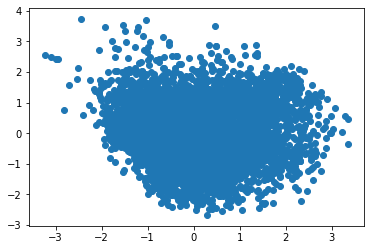

0 -3.2415541127611864 3.358940396691222
Iteration   50, KL divergence  1.9082, 50 iterations in 18.0553 sec
Iteration  100, KL divergence  1.6248, 50 iterations in 17.7505 sec
Iteration  150, KL divergence  1.4920, 50 iterations in 17.7292 sec
Iteration  200, KL divergence  1.4173, 50 iterations in 17.5739 sec
Iteration  250, KL divergence  1.3728, 50 iterations in 17.4749 sec


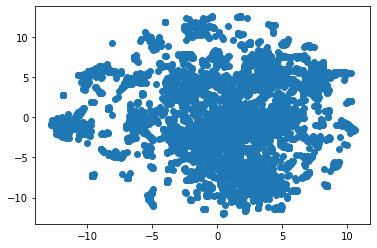

1 -12.833508452604256 10.563694778877489
Iteration   50, KL divergence  1.3240, 50 iterations in 17.5991 sec
Iteration  100, KL divergence  1.3032, 50 iterations in 17.5168 sec
Iteration  150, KL divergence  1.2928, 50 iterations in 17.4121 sec
Iteration  200, KL divergence  1.2872, 50 iterations in 17.5839 sec
Iteration  250, KL divergence  1.2838, 50 iterations in 17.7169 sec
Iteration  300, KL divergence  1.2816, 50 iterations in 17.4789 sec
Iteration  350, KL divergence  1.2800, 50 iterations in 21.1844 sec
Iteration  400, KL divergence  1.2793, 50 iterations in 18.3162 sec
Iteration  450, KL divergence  1.2784, 50 iterations in 17.6962 sec
Iteration  500, KL divergence  1.2787, 50 iterations in 17.5250 sec
Iteration  550, KL divergence  1.2774, 50 iterations in 17.5949 sec
Iteration  600, KL divergence  1.2772, 50 iterations in 18.1869 sec
Iteration  650, KL divergence  1.2771, 50 iterations in 17.4797 sec
Iteration  700, KL divergence  1.2767, 50 iterations in 17.4506 sec
Iterati

2 -25.821239051809126 21.531346230054602
Iteration   50, KL divergence  2.1328, 50 iterations in 1.9802 sec
Iteration  100, KL divergence  2.0737, 50 iterations in 2.1468 sec
Iteration  150, KL divergence  2.0135, 50 iterations in 2.1606 sec
Iteration  200, KL divergence  1.9559, 50 iterations in 2.5713 sec
Iteration  250, KL divergence  1.9058, 50 iterations in 3.1181 sec
Iteration  300, KL divergence  1.8646, 50 iterations in 3.0823 sec
Iteration  350, KL divergence  1.8342, 50 iterations in 3.3245 sec
Iteration  400, KL divergence  1.8096, 50 iterations in 3.4788 sec
Iteration  450, KL divergence  1.7911, 50 iterations in 3.5458 sec
Iteration  500, KL divergence  1.7761, 50 iterations in 4.2948 sec


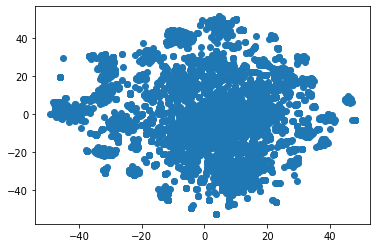

3 -49.096188843824265 47.89581340098373
embedding optimize done 2020-03-26 17:03:05.739574


In [49]:
X_svd = pd.read_pickle(os.path.join(res, '{}_X_svd.pickle'.format(name)))
for init_name, init_train in {
    'random': initialization.random(X_svd, random_state=42),
    'pca': initialization.pca(X_svd, random_state=42)
}.items():
    print(init_name, datetime.now())
    affinities_train = affinity.PerplexityBasedNN(
    X_svd, perplexity=perps[0], metric='cosine', n_jobs=1, random_state=42)
    print('perplexity nn done', datetime.now())
    embedding_train = TSNEEmbedding(
        init_train,
        affinities_train,
        negative_gradient_method="fft",
        n_jobs=3,
        callbacks=ErrorLogger()
    )
    print('embedding done', datetime.now())
    embedding_train[:, 0] *= 100
    embedding_train[:, 1] *= 100
    plt.scatter(embedding_train[:,0], embedding_train[:,1])
    plt.show()
    plt.close()
    print('0', np.min(embedding_train[:,0]), np.max(embedding_train[:,0]))
    embedding_train_1 = embedding_train.optimize(n_iter=250, momentum=0.5)
    plt.scatter(embedding_train_1[:,0], embedding_train_1[:,1])
    plt.show()
    plt.close()
    print('1', np.min(embedding_train_1[:,0]), np.max(embedding_train_1[:,0]))
    embedding_train_2 = embedding_train_1.optimize(n_iter=750, momentum=0.8)
    plt.scatter(embedding_train_2[:,0], embedding_train_2[:,1])
    plt.show()
    plt.close()
    print('2', np.min(embedding_train_2[:,0]), np.max(embedding_train_2[:,0]))
    affinities_train.set_perplexity(perps[1])
    embedding_train_3 = embedding_train_2.optimize(n_iter=500, momentum=0.8)
    plt.scatter(embedding_train_3[:,0], embedding_train_3[:,1])
    plt.show()
    plt.close()
    print('3', np.min(embedding_train_3[:,0]), np.max(embedding_train_3[:,0]))
    print('embedding optimize done', datetime.now())
    pickle.dump(np.array(embedding_train_2.tolist()), open(os.path.join(res, 
        '{}_embedding_{}_{}.pickle'.format(
        name, perps[0], init_name)), 'wb'))
    pickle.dump(np.array(embedding_train_3.tolist()), open(os.path.join(res,
        '{}_embedding_{}_{}_{}.pickle'.format(
        name, perps[0], perps[1], init_name)), 'wb'))

### Analysis

To examine whether the placing of articles in 2D space is meaningful, a preliminary analysis is presented. Let's identify articles that contain the word "Facebook" and see their location.    

In [50]:
embeddings_train = {}
for init_name in ['random', 'pca']:
    embeddings_train[init_name] = pd.read_pickle(os.path.join(res,
                                                              '{}_embedding_{}_{}_{}.pickle'.format(
                                                                 name, perps[0], perps[1], init_name)))
    
embeddings_trainfacebook_in = pd.read_pickle(os.path.join(res, '{}_word_indices.pickle'.format(name)))


pca


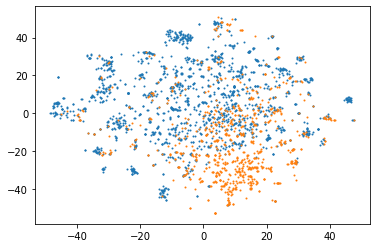

random


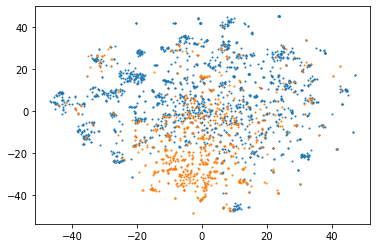

In [51]:
for init_name in ['pca', 'random']:
    print(init_name)
    plt.scatter(x=embeddings_train[init_name][sample_numbers[~facebook_in[sample_numbers]],0],
                y=embeddings_train[init_name][sample_numbers[~facebook_in[sample_numbers]],1],
               s=1)

    plt.scatter(x=embeddings_train[init_name][sample_numbers[facebook_in[sample_numbers]],0],
                y=embeddings_train[init_name][sample_numbers[facebook_in[sample_numbers]],1],
               s=1)
    plt.show()
    plt.close()

Facebook is a general topic, nevertheless PCA seems to do a slightly better job in making the topics related to Facebook be closer to the main topic of Facebook, which is clear for both initializations. Let us try another topics, for example drones and spacex. They are vaguely related – but should clearly be in different clusters. For larger datasets, the improvement by using PCA should be more clear.

In [137]:
df = pd.read_pickle(os.path.join(res, '{}_df.pickle'.format(name)))

In [138]:
indices_1 = df[text_column + '_token_count'].apply(lambda x: 'drone' in x).values
indices_2 = df[text_column + '_token_count'].apply(lambda x: 'spacex' in x).values

In [139]:
sum(indices_1), sum(indices_2)

(183, 79)

pca


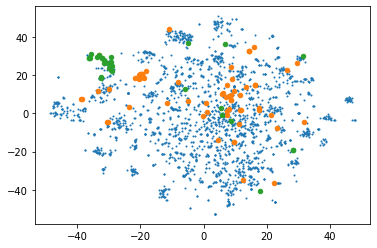

random


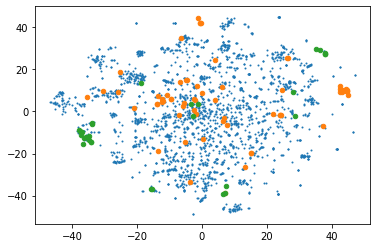

In [140]:
for init_name in ['pca', 'random']:
    print(init_name)
    plt.scatter(x=embeddings_train[init_name][sample_numbers[~indices_1[sample_numbers] & ~indices_2[sample_numbers]],0],
                y=embeddings_train[init_name][sample_numbers[~indices_1[sample_numbers] & ~indices_2[sample_numbers]],1],
               s=1)

    plt.scatter(x=embeddings_train[init_name][sample_numbers[indices_1[sample_numbers]],0],
                y=embeddings_train[init_name][sample_numbers[indices_1[sample_numbers]],1],
               s=20)
    
    plt.scatter(x=embeddings_train[init_name][sample_numbers[indices_2[sample_numbers]],0],
                y=embeddings_train[init_name][sample_numbers[indices_2[sample_numbers]],1],
               s=20)
    plt.show()
    plt.close()

### T-sne with LDA

How do the clusters prepared with T-sne compare to the LDA topics from the previous tutorial? 
Let us now create an interactive visualization. 
The location of the articles is assigned with T-sne, while the colors are determined by the dominant topics assigned in the LDA analysis.


In [147]:
for init_name in ['pca', 'random']:
    df['x_{}'.format(init_name)] = embeddings_train[init_name][:,0]
    df['y_{}'.format(init_name)] = embeddings_train[init_name][:,1]

In [143]:
df_sh = df.iloc[sample_numbers]

In [144]:
df_sh

level_0  index  Unnamed: 0  \
587       587    115        5756   
6202     6202     11         132   
5363     5363     47         971   
4168     4168     19        2169   
398       398    163        5945   
...       ...    ...         ...   
3154     3154     23        3186   
4942     4942      7        1394   
1472     1472     94        4870   
2662     2662     60        3678   
3341     3341     91        2998   

                                                  title      site  \
587    Sour grapes at Facebook over Google's AI victory  guardian   
6202  How do I find a smartphone with the specificat...  guardian   
5363          Apple launches new iPad Mini and iPad Air  guardian   
4168  Teenage flicks: how 'phone boredom' became Gen...  guardian   
398   Oregon man pleads guilty to stealing nude and ...  guardian   
...                                                 ...       ...   
3154  Google reportedly fires author of anti-diversi...  guardian   
4942  Apple's value dips below $1tn amid fears of iP...  guardian   
1472  How a robot lover pioneered the driverless car...  guardian   
2662  'Exciting times'? Changes in technology can bo...  guardian   
3341  Driverless cars: safer perhaps, but professor ...  guardian   

                                                    url year_month  \
587   https://www.theguardian.com/technology/2016/ma...    2016-03   
6202  https://www.theguardian.com/technology/askjack...    2020-01   
5363  https://www.theguardian.com/technology/2019/ma...    2019-03   
4168  https://www.theguardian.com/technology/shortcu...    2018-04   
398   https://www.theguardian.com/technology/2016/fe...    2016-02   
...                                                 ...        ...   
3154  https://www.theguardian.com/technology/2017/au...    2017-08   
4942  https://www.theguardian.com/business/2018/nov/...    2018-11   
1472  https://www.theguardian.com/technology/2016/au...    2016-08   
2662  https://www.theguardian.com/technology/2017/ap...    2017-04   
3341  https://www.theguardian.com/technology/2017/se...    2017-09   

       full_date                                   text_token_count         0  \
587   2016-03-15  {'sour': 2, 'grape': 2, 'at': 2, 'facebook': 7...  1.106911   
6202  2020-01-09  {'how': 1, 'do': 6, 'i': 15, 'find': 6, 'a': 4...  0.181170   
5363  2019-03-18  {'appl_launch': 1, 'new': 10, 'ipad_mini': 6, ...  0.075233   
4168  2018-04-04  {'teenag': 2, 'flick': 1, ':': 11, 'how': 2, '...  0.766618   
398   2016-02-20  {'oregon': 3, 'man': 1, 'plead': 2, 'guilti': ...  2.389718   
...          ...                                                ...       ...   
3154  2017-08-08  {'googl': 21, 'report': 2, 'fire': 5, 'author'...  0.737254   
4942  2018-11-02  {'appl': 13, ''s': 8, 'valu': 3, 'dip': 2, 'be...  0.500842   
1472  2016-08-19  {'how': 2, 'a': 30, 'robot': 9, 'lover': 1, 'p...  0.442700   
2662  2017-04-14  {'excit': 2, 'time': 2, ''': 2, '?': 3, 'chang...  0.321724   
3341  2017-09-22  {'driverless_car': 5, ':': 4, 'safer': 2, 'per...  0.960285   

      ...   topic25   topic26   topic27   topic28   topic29  maxtopic  \
587   ...  0.527966  0.000000  0.000000  1.637572  0.000000        28   
6202  ...  0.464044  0.000000  2.623870  0.000000  0.000000        27   
5363  ...  0.000000  0.664821  2.750211  0.000000  0.000000         9   
4168  ...  0.000000  0.596843  0.000000  0.000000  0.000000         2   
398   ...  2.317861  0.683313  0.000000  0.000000  0.000000         0   
...   ...       ...       ...       ...       ...       ...       ...   
3154  ...  0.000000  0.000000  0.000000  0.000000  0.508095        23   
4942  ...  0.578310  0.000000  0.178062  0.000000  0.000000         9   
1472  ...  2.326578  0.259623  0.000000  0.000000  0.000000        25   
2662  ...  0.000000  0.000000  0.000000  0.000000  0.000000         8   
3341  ...  1.441412  0.000000  0.000000  0.000000  0.000000        23   

          x_pca      y_pca   x_random   y_random  
58

To make the visualisation more focused, separate colours are assigned to the 9 most important topics, while the remaining ones will be treated as one topic (named topic 99)


In [145]:
df_sh['maxtopic']=df_sh['maxtopic'].map({k: (k if k not in df_sh['maxtopic'].value_counts()[9:].index else 99) for k in df_sh['maxtopic'].unique()})

/Users/kristof/anaconda3/envs/myPython/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [148]:
for init_name in ['random', 'pca']:
    all_data = []
    for maxtopic, df_sh_topic in df_sh.groupby('maxtopic'):
        all_data.append({
            'x': df_sh_topic['x_{}'.format(init_name)], 'y': df_sh_topic['y_{}'.format(init_name)],
            'text': df_sh_topic['title'],
            'fillcolor': '#%02x%02x%02x' % cm.viridis(maxtopic, bytes=True)[:-1],
            'mode': 'markers',
            'name': maxtopic,
            'marker': {'size': 5,
                      }
        })

    plot({'data': all_data},
        filename=os.path.join(res, 'all_guardian_{}.html'.format(init_name)))

Two visualisation appear in separate tabs in the browser and are saved locally as well.

You can examine the titles of the articles: articles on the same subject should be close to each other. Similarly to our report (https://fwd.delabapps.eu/topic_modelling.html), the method works very well in identifying small topic clusters, especially outside the centre of the visualisation.

The LDA topics are also meaningful, as small clusters tend to have articles with the same dominant topic, hence the same colour. 

To conclude, LDA is a great tool to identify large topics and characteristic terms. In order to dive deeper in these topics, t-SNE is highly effective.